# Prepare Labelled Data

This notebook prepares the labelled data to train the linear regression and neural network model to predict continuous sentiment scores based on word2vec and fasttext word embeddings. 

### Dependencies

In [1]:
import re, os
import numpy as np
import pandas as pd
import itertools
from gensim.models import KeyedVectors, FastText

### Sentiment Lexicon: Sentida2

Below, the sentiment lexicon sentida2 is loaded and inspected. It was extracted from [Github](https://github.com/Guscode/Sentida2). 

In [2]:
# loading sentiment lexicon
sentiments = pd.read_csv("../../lexicons/sentida2_lexicon.csv")
# print the how many scores
print(len(sentiments))
sentiments[:5]

6592


,word,score
0,abe,-1.000000
1,abort,-0.333333
2,absolut,0.333333
3,abstrakt,0.666667
4,absurd,-2.333333


### Word Embeddings: Word2Vec

In [3]:
# load word2vec word embeddings
word2vec = KeyedVectors.load_word2vec_format("../../embeddings/semantic_model_DAGW_cbow.wv.bin", binary=True)
# create emtpty dictionary
w2v_dict = {}
# put word2vec data into dictionary
for idx, key in enumerate(word2vec.key_to_index):
    w2v_dict[key] = word2vec[key]

__Matching sentida2 sentiment scores with corresponding word embeddings__

In [4]:
y = [] # empty list for embeddings
X = [] # empty list for labels (sentiment scores)
not_found = [] # empty list for word in sentida2 for which no embeddings could be found

for index, row in sentiments.iterrows():
    raw_word = row["word"] # take the word
    word = raw_word.lower() # lowercase the word
    sent = row["score"] # get the score
    # if the word exist in word2vec, append to lists
    if word in w2v_dict: 
        embed = w2v_dict[word]
        y.append(sent)
        X.append(embed)
    # otherwise append to not found
    else:
        not_found.append(word)

In [6]:
# save not found words
textfile = open("../../appendix/not_found_w2v_sentida2.txt", "w")
for element in not_found:
    textfile.write(element + "\n")
textfile.close()

In [5]:
print(len(not_found))

172


In [7]:
# save X and y arrays
X_array = np.array(X)
y_array = np.array(y)

print("Shape of X:", X_array.shape, "; Shape of y:", y_array.shape)

np.save("../../data/labelled_data/X_w2v_asent.npy", X_array)
np.save("../../data/labelled_data/y_w2v_asent.npy", y_array)

Shape of X: (6420, 300) ; Shape of y: (6420,)


### FastText

In [11]:
# load fasttext embedding model
ft_model = FastText.load("../../../../dagw_fasttext_embeddings/fasttext_model/fasttext.model")

In [16]:
ft_y = [] # empty list for embeddings
ft_X = [] # empty list for labels (sentiment scores)
ft_not_found = [] # empty list of not founc

for index, row in sentiments.iterrows():
    raw_word = row["word"]
    word = raw_word.lower()
    sent = row["score"]
    if word in ft_model.wv:
        embed = ft_model.wv[word]
        ft_y.append(sent)
        ft_X.append(embed)
    else:
        ft_not_found.append(word)

In [18]:
len(ft_not_found)

0

In [20]:
# save X and y arrays
X_ft_array = np.array(ft_X)
y_ft_array = np.array(ft_y)

print("Shape of X:", X_ft_array.shape, "; Shape of y:", y_ft_array.shape)

np.save("../../data/labelled_data/X_ft_asent.npy", X_ft_array)
np.save("../../data/labelled_data/y_ft_asent.npy", y_ft_array)

Shape of X: (6592, 300) ; Shape of y: (6592,)


In [13]:
# extra: some lemmas are not in the vocabulary of fasttext, but estimated using the trained-subwords, here we find them
in_ft_voc=[]

for index, row in sentiments.iterrows():
    raw_word = row["word"]
    word = raw_word.lower()
    if word in ft_model.wv.key_to_index:
        in_ft_voc.append(index)
        
print(len(in_ft_voc)) # are in fasttext vocabulary
print(6952-len(in_ft_voc)) # are estimated from subwords

6500
452


**Loading 10k Lemmas**

In [2]:
# load 10k word list
lemmas10 = pd.read_csv('../../lemmas/lemma-10k-2017-ex.txt', sep = "\t", header = None)
lemmas10 = lemmas10.rename(columns={0: "POS", 1: "word", 2: "freq"})
# Remove irrelevant POS 
pos_tags = ["A", "D", "NC", "V", "I"]
lemmas_relevant = lemmas10[lemmas10['POS'].isin(pos_tags)]
print(len(lemmas10), len(lemmas_relevant))

10000 9828


**Loading Sentiments of Asent == Sentida2**

In [20]:
# sentiments
sentiments = pd.read_csv("../../lexicons/sentida2_lexicon.csv", encoding='ISO-8859-1')
print(len(sentiments))
sentiments

5263


,Unnamed: 0,X,stem,score
0,1,1,abe,-1.000000
1,2,2,abort,-0.333333
2,3,3,absolut,0.333333
3,4,4,abstrak,0.666667
4,5,5,absurd,-2.333333
...,...,...,...,...
5258,5259,5259,årsdag,0.666667
5259,5260,5260,årsregnskab,-0.333333
5260,5261,5261,årvåg,3.000000
5261,5262,5262,årvågent,3.000000


**Remove the ones that are in lemmas but not in asent == neutral?!**

In [4]:
# add neutral words that are not in asent, assuming they are the ones that were excluded
lemmas_noasent = lemmas_relevant[~lemmas_relevant['word'].isin(sentiments["word"].tolist())]
lemmas_asent = lemmas_relevant[lemmas_relevant['word'].isin(sentiments["word"].tolist())]

In [5]:
print(len(lemmas_noasent), len(lemmas_asent))

4150 5678


In [6]:
set(lemmas_noasent["POS"])

{'A', 'D', 'I', 'NC', 'V'}

In [7]:
lemmas_noasent[:10]

,POS,word,freq
1,V,være,0.030902
10,V,have,0.014093
16,D,ikke,0.009249
17,V,kunne,0.006831
18,V,blive,0.006398
26,V,skulle,0.004602
27,D,så,0.004213
29,V,ville,0.004152
33,V,sige,0.003713
34,NC,år,0.003562


In [10]:
# save neutral
textfile = open("../appendix/neutral_words.txt", "w")
for element in lemmas_noasent["word"]:
    textfile.write(element + "\n")
textfile.close()

**Add not in asent as neutral to all sentiments**

In [8]:
neutral_words = pd.DataFrame({"word": lemmas_noasent["word"], "score": 0})
neutral_words[:10]

,word,score
1,være,0
10,have,0
16,ikke,0
17,kunne,0
18,blive,0
26,skulle,0
27,så,0
29,ville,0
33,sige,0
34,år,0


In [9]:
neutral_sample = neutral_words.sample(1069)

In [10]:
all_sentiments = pd.concat([sentiments, neutral_sample])
print(len(all_sentiments))

7661


In [11]:
all_sentiments[:10]

,word,score
0,abe,-1.000000
1,abort,-0.333333
2,absolut,0.333333
3,abstrakt,0.666667
4,absurd,-2.333333
5,accelerere,1.333333
6,accept,1.333333
7,acceptabel,1.666667
8,acceptere,1.666667
9,action,0.666667


In [14]:
# save all sentiments
all_sentiments.to_csv("../data/all_sentiments.csv")

## Word2Vec

In [21]:
word2vec = KeyedVectors.load_word2vec_format("../../embeddings/semantic_model_DAGW_cbow.wv.bin", binary=True)
w2v_dict = dict({})
for idx, key in enumerate(word2vec.key_to_index):
    w2v_dict[key] = word2vec[key]

In [42]:
w2v_dict["glemte"]

array([-5.44577390e-02, -1.95206292e-02, -5.21334074e-02, -3.63027714e-02,
        3.16028632e-02, -4.82380986e-02, -2.97096968e-02,  5.71238063e-02,
       -8.20544083e-03,  1.41782770e-02, -2.00094413e-02,  2.07450497e-03,
        5.30896522e-02, -3.18971500e-02,  5.52097224e-02, -1.45272305e-02,
       -2.79464107e-02, -7.88782090e-02, -8.78869146e-02,  2.97148898e-02,
       -6.26806915e-02, -6.75774515e-02, -1.64186843e-02,  2.36200634e-03,
       -6.16080016e-02,  1.70091186e-02,  2.11043395e-02, -1.25539757e-03,
       -3.77942692e-03,  2.05034167e-02, -3.28624691e-03, -3.09932865e-02,
       -5.50933294e-02,  8.24128240e-02,  6.55494183e-02,  2.80603599e-02,
        1.18187163e-02,  2.51543950e-02,  1.99077446e-02, -6.44484302e-03,
       -6.17770851e-02,  5.34106158e-02, -5.26156500e-02,  5.00716530e-02,
       -8.78605247e-02,  3.96079272e-02,  4.51625548e-02,  5.23860045e-02,
       -7.07231611e-02,  5.22112995e-02, -5.58102131e-02,  5.78433312e-02,
        6.42338991e-02, -

In [22]:
y = []
X = []
not_found = []

for index, row in sentiments.iterrows():
    raw_word = row["stem"]
    word = raw_word.lower()
    sent = row["score"]
    if word in w2v_dict: 
        embed = w2v_dict[word]
        y.append(sent)
        X.append(embed)
    else:
        not_found.append(word)

In [23]:
print("embeddings:", len(X), "; sentiment labels:", len(y), "; not embedding found:", len(not_found))

embeddings: 4812 ; sentiment labels: 4812 ; not embedding found: 451


In [31]:
textfile = open("../../appendix/not_found_sentida.txt", "w")
for element in not_found["stem"]:
    textfile.write(element + "\n")
textfile.close()

FileNotFoundError: [Errno 2] No such file or directory: '../appendix/not_found_sentida.txt'

In [24]:
# save X and y arrays
X_array = np.array(X)
y_array = np.array(y)

print("Shape of X:", X_array.shape, "; Shape of y:", y_array.shape)

np.save("../../data/training_data/X_w2v_sentida.npy", X_array)
np.save("../../data/training_data/y_w2v_sentida.npy", y_array)

Shape of X: (4812, 300) ; Shape of y: (4812,)


## FastText 

In [28]:
ft_model = FastText.load("../../../../dagw_fasttext_embeddings/fasttext_model/fasttext.model")

In [29]:
ft_y = []
ft_X = []
ft_not_found = []

for index, row in sentiments.iterrows():
    raw_word = row["stem"]
    word = raw_word.lower()
    sent = row["score"]
    if word in ft_model.wv:
        embed = ft_model.wv[word]
        ft_y.append(sent)
        ft_X.append(embed)
    else:
        ft_not_found.append(word)

In [30]:
print("embeddings:", len(ft_X), "; sentiment labels:", len(ft_y), "; not embedding found:", len(ft_not_found))

embeddings: 5263 ; sentiment labels: 5263 ; not embedding found: 0


In [65]:
# save X and y arrays
X_ft_array = np.array(ft_X)
y_ft_array = np.array(ft_y)

print("Shape of X:", X_ft_array.shape, "; Shape of y:", y_ft_array.shape)

np.save("../data/training_data/X_ft_array_neutral.npy", X_ft_array)
np.save("../data/training_data/y_ft_array_neutral.npy", y_ft_array)

Shape of X: (10742, 300) ; Shape of y: (10742,)


In [4]:
y = np.load("../../data/training_data/y_w2v_neutral.npy")
y = 

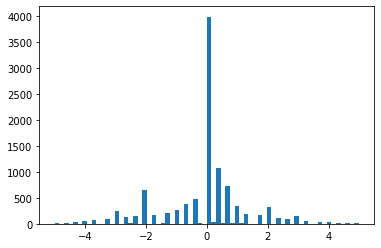

In [9]:
import matplotlib.pyplot as plt
plt.hist(y, bins=66);

In [12]:
y_no = y[y != 0]

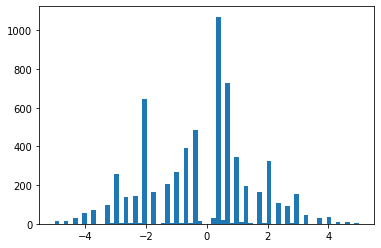

In [13]:
plt.hist(y_no, bins=66);

In [15]:
unique, counts = np.unique(y_no, return_counts=True)
np.asarray((unique, counts)).T

array([[-5.00000000e+00,  1.50000000e+01],
       [-4.66666667e+00,  1.60000000e+01],
       [-4.33333333e+00,  2.80000000e+01],
       [-4.16666667e+00,  1.00000000e+00],
       [-4.00000000e+00,  5.60000000e+01],
       [-3.66666667e+00,  6.90000000e+01],
       [-3.66666667e+00,  2.00000000e+00],
       [-3.50000000e+00,  1.00000000e+00],
       [-3.33333333e+00,  9.70000000e+01],
       [-3.16666667e+00,  2.00000000e+00],
       [-3.00000000e+00,  2.56000000e+02],
       [-2.83333333e+00,  2.00000000e+00],
       [-2.66666667e+00,  1.38000000e+02],
       [-2.50000000e+00,  6.00000000e+00],
       [-2.33333333e+00,  1.46000000e+02],
       [-2.16666667e+00,  2.00000000e+00],
       [-2.00000000e+00,  6.44000000e+02],
       [-1.66666667e+00,  1.64000000e+02],
       [-1.50000000e+00,  6.00000000e+00],
       [-1.33333333e+00,  2.07000000e+02],
       [-1.16666667e+00,  4.00000000e+00],
       [-1.00000000e+00,  2.70000000e+02],
       [-8.33333333e-01,  3.00000000e+00],
       [-6.

In [17]:
counts

array([  15,   16,   28,    1,   56,   69,    2,    1,   97,    2,  256,
          2,  138,    6,  146,    2,  644,  164,    6,  207,    4,  270,
          3,  390,    3,    1,  483,   16,    1,   30, 1069,    1,   19,
        726,    1,    5,  345,    1,    8,  193,    4,  166,    5,  322,
        106,    1,    1,   92,    2,  155,    1,   45,   28,   37,   11,
         10,    6])